# Importing Switzerland's Airspaces

We import data on the Switzerland's airspaces from [OpenAIP](http://www.openaip.net/) and convert it to OpenAir format using one of the following tools:
- https://github.com/openAIP/airspace-converter
- https://github.com/alus-it/AirspaceConverter

We use this data to build a dataframe that can be used with the rest of our code.

Latest data: http://www.openaip.net/system/files/airspaces/openaip_airspace_switzerland_ch.aip_1600822879

Note that OpenAIP requires a (free) account to download files.

We use [python-openair](https://github.com/jsmailes/python-openair) to process the OpenAir file, ensure this is installed and on your PYTHONPATH.

## Setup

Modify the location below to point to the OpenAir file.

In [1]:
openair_file = "/mnt/cold_data/josh/dumped/openaip_airspace_switzerland_ch.txt"

In [2]:
import openair

In [3]:
import requests
from datetime import datetime, timezone
import time
import numpy as np
import pandas as pd
import descartes, geopandas
import cartopy
from shapely.geometry import LineString, Point, Polygon, MultiPolygon, base
import pyproj
from shapely.ops import transform, unary_union
import math
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature

import re

In [4]:
heightstring = r"^(?P<fl>(FL|fl) ?(?P<fl_val>\d+))|(?P<msl>(?P<msl_val>\d+) ?(msl|MSL))|(?P<agl>(?P<agl_val>\d+) ?(agl|AGL))|(?P<fl_agl>(?P<fl_agl_val>\d+) ?(fl|FL) (agl|AGL))|(?P<m_agl>(?P<m_agl_val>\d+) ?(m|M) (agl|AGL))|(?P<gnd>gnd|GND)|(?P<f_msl>(?P<f_msl_val>\d+) ?(f|F) (msl|MSL))|(?P<f_gnd>(?P<f_gnd_val>\d+) ?(f|F) (gnd|GND))$"
positionstring = r"^(?P<ns_d>\d{1,2}):(?P<ns_m>\d{1,2}):(?P<ns_s>\d{1,2}) ?(?P<ns>[NS]) ?(?P<ew_d>\d{1,3}):-?(?P<ew_m>\d{1,2}):(?P<ew_s>\d{1,2}) ?(?P<ew>[EW])$"

expression_height = re.compile(heightstring)
expression_position = re.compile(positionstring)

## Initial Data Processing

The airspaces are loaded from the OpenAir file and turned into a DataFrame with the help of a parsing library and a series of regular expressions.

In [5]:
airspaces = openair.parseFile(openair_file)

In [6]:
df = pd.DataFrame(airspaces)

df.columns = ['name', 'upper_limit_raw', 'lower_limit_raw', 'coords_raw']

In [7]:
def metre_to_ft(x):
    return x * 3.28084

def process_height(string):
    match = expression_height.match(string)
    if match is not None:
        if match.group('fl') is not None:
            return int(match.group('fl_val')) * 100
        elif match.group('msl') is not None:
            return int(match.group('msl_val'))
        elif match.group('agl') is not None:
            return int(match.group('agl_val'))
        elif match.group('fl_agl') is not None:
            return int(match.group('fl_agl_val')) * 100
        elif match.group('m_agl') is not None:
            return metre_to_ft(int(match.group('m_agl_val')))
        elif match.group('f_msl') is not None:
            return int(match.group('f_msl_val'))
        elif match.group('f_gnd') is not None:
            return int(match.group('f_gnd_val'))
        elif match.group('gnd') is not None:
            return 0
        else:
            raise Exception(string)
    else:
        raise Exception(string)

In [8]:
def position_to_decimal(degrees, minutes, seconds, direction):
    return direction * (degrees + ((1/60) * minutes) + ((1/3600) * seconds))

def process_position(string):
    match = expression_position.match(string)
    if match is not None:
        ns_deg = int(match.group('ns_d'))
        ns_min = int(match.group('ns_m'))
        ns_sec = int(match.group('ns_m'))
        ns_dir = 1 if match.group('ns') == "N" else -1
        latitude = position_to_decimal(ns_deg, ns_min, ns_sec, ns_dir)
        
        ew_deg = int(match.group('ew_d'))
        ew_min = int(match.group('ew_m'))
        ew_sec = int(match.group('ew_m'))
        ew_dir = 1 if match.group('ew') == "E" else -1
        longitude = position_to_decimal(ew_deg, ew_min, ew_sec, ew_dir)
        
        return [latitude, longitude] # TODO figure out if right way round
    else:
        raise Exception(string)

def process_positions(positions):
    if isinstance(positions, list):
        return [ process_position(pos) for pos in positions ]
    else:
        return None

def coords_to_points(coords):
    if coords is None:
        return geopandas.points_from_xy([], [])
    lats, longs = zip(*coords)
    return geopandas.points_from_xy(longs, lats)

def geometry_lambda(positions):
    poly = Polygon(coords_to_points(process_positions(positions))).buffer(0)
    if isinstance(poly, Polygon):
        return MultiPolygon([poly])
    else:
        return MultiPolygon(poly)

In [9]:
df['lower_limit'] = df.lower_limit_raw.apply(process_height)
df['upper_limit'] = df.upper_limit_raw.apply(process_height)
df['coords'] = df.coords_raw.apply(process_positions)
df['geometry'] = df.coords_raw.apply(geometry_lambda)

In [10]:
df

name upper_limit_raw lower_limit_raw  \
0                  A9.1 AIRWAY          FL 195           FL 90   
1                  A9.2 AIRWAY          FL 195          FL 130   
2    Aiguilles Rouges 300m AGL       3300F GND             GND   
3                Alpen Mil off          FL 195          FL 150   
4                 Alpen Mil on          FL 195          FL 130   
..                         ...             ...             ...   
147         ZURICH 5 TMA 118.1          FL 195       3500F MSL   
148         ZURICH 6 TMA 118.1          FL 195       5500F MSL   
149         ZURICH 7 TMA 118.1          FL 195       7500F MSL   
150         ZURICH 8 TMA 118.1          FL 195       6500F MSL   
151         ZURICH 9 TMA 118.1          FL 195       7500F MSL   

                                            coords_raw  lower_limit  \
0    [47:15:18 N 008:58:21 E, 47:13:03 N 008:55:26 ...         9000   
1    [47:02:49 N 008:56:49 E, 46:52:13 N 008:58:16 ...        13000   
2    [45:55:20 N 006:50:06 E, 45:55:21 N 006:49:49 ...            0   
3    [46:22:02 N 006:48:18 E, 46:31:43 N 007:03:52 ...        15000   
4    [46:22:02 N 006:48:18 E, 46:31:43 N 007:03:52 ...        13000   
..                                                 ...          ...   
147  [47:29:54 N 008:54:28 E, 47:26:19 N 008:53:32 ...         3500   
148  [47:46:04 N 008:25:06 E, 47:43:28 N 008:18:17 ...         5500   
149  [47:18:10 N 008:22:40 E, 47:13:56 N 008:25:55 ...         7500   
150  [47:38:34 N 008:00:00 E, 47:34:34 N 007:59:59 ...         6500   
151  [47:51:45 N 008:46:30 E, 47:49:51 N 008:39:21 ...         7500   

     upper_limit                                             coords  \
0          19500  [[47.25416666666667, 8.982777777777779], [47.2...   
1          19500  [[47.03388888888889, 8.94888888888889], [46.88...   
2           3300  [[45.93194444444444, 6.847222222222222], [45.9...   
3          19500  [[46.37277777777778, 6.8133333333333335], [46....   
4          19500  [[46.37277777777778, 6.8133333333333335], [46....   
..           ...                                                ...   
147        19500  [[47.49138888888889, 8.915000000000001], [47.4...   
148        19500  [[47.779444444444444, 8.42361111111111], [47.7...   
149        19500  [[47.305, 8.372777777777777], [47.220277777777...   
150        19500  [[47.64388888888889, 8.0], [47.57611111111112,...   
151        19500  [[47.86416666666667, 8.779444444444444], [47.8...   

                                              geometry  
0    (POLYGON ((8.982777777777779 47.25416666666667...  
1    (POLYGON ((8.94888888888889 47.03388888888889,...  
2    (POLYGON ((6.847222222222222 45.93194444444444...  
3    (POLYGON ((6.813333333333333 46.37277777777778...  
4    (POLYGON ((6.813333333333333 46.37277777777778...  
..                                                 ...  
147  (POLYGON ((8.915000000000001 47.49138888888889...  
148  (POLYGON ((8.423611111111111 47.77944444444444...  
149  (POLYGON ((8.372777777777777 47.305, 8.4236111...  
150  (POLYGON ((8 47.64388888888889, 7.999722222222...  
151  (POLYGON ((8.779444444444444 47.86416666666667...  

[152 rows x 8 columns]

In [11]:
gdf = geopandas.GeoDataFrame(df, geometry=df.geometry)
gdf.set_crs(epsg=4326, inplace=True)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Visualising Airspaces

We can now plot the airspaces on a map, and plot the airspaces which intersect a given point.

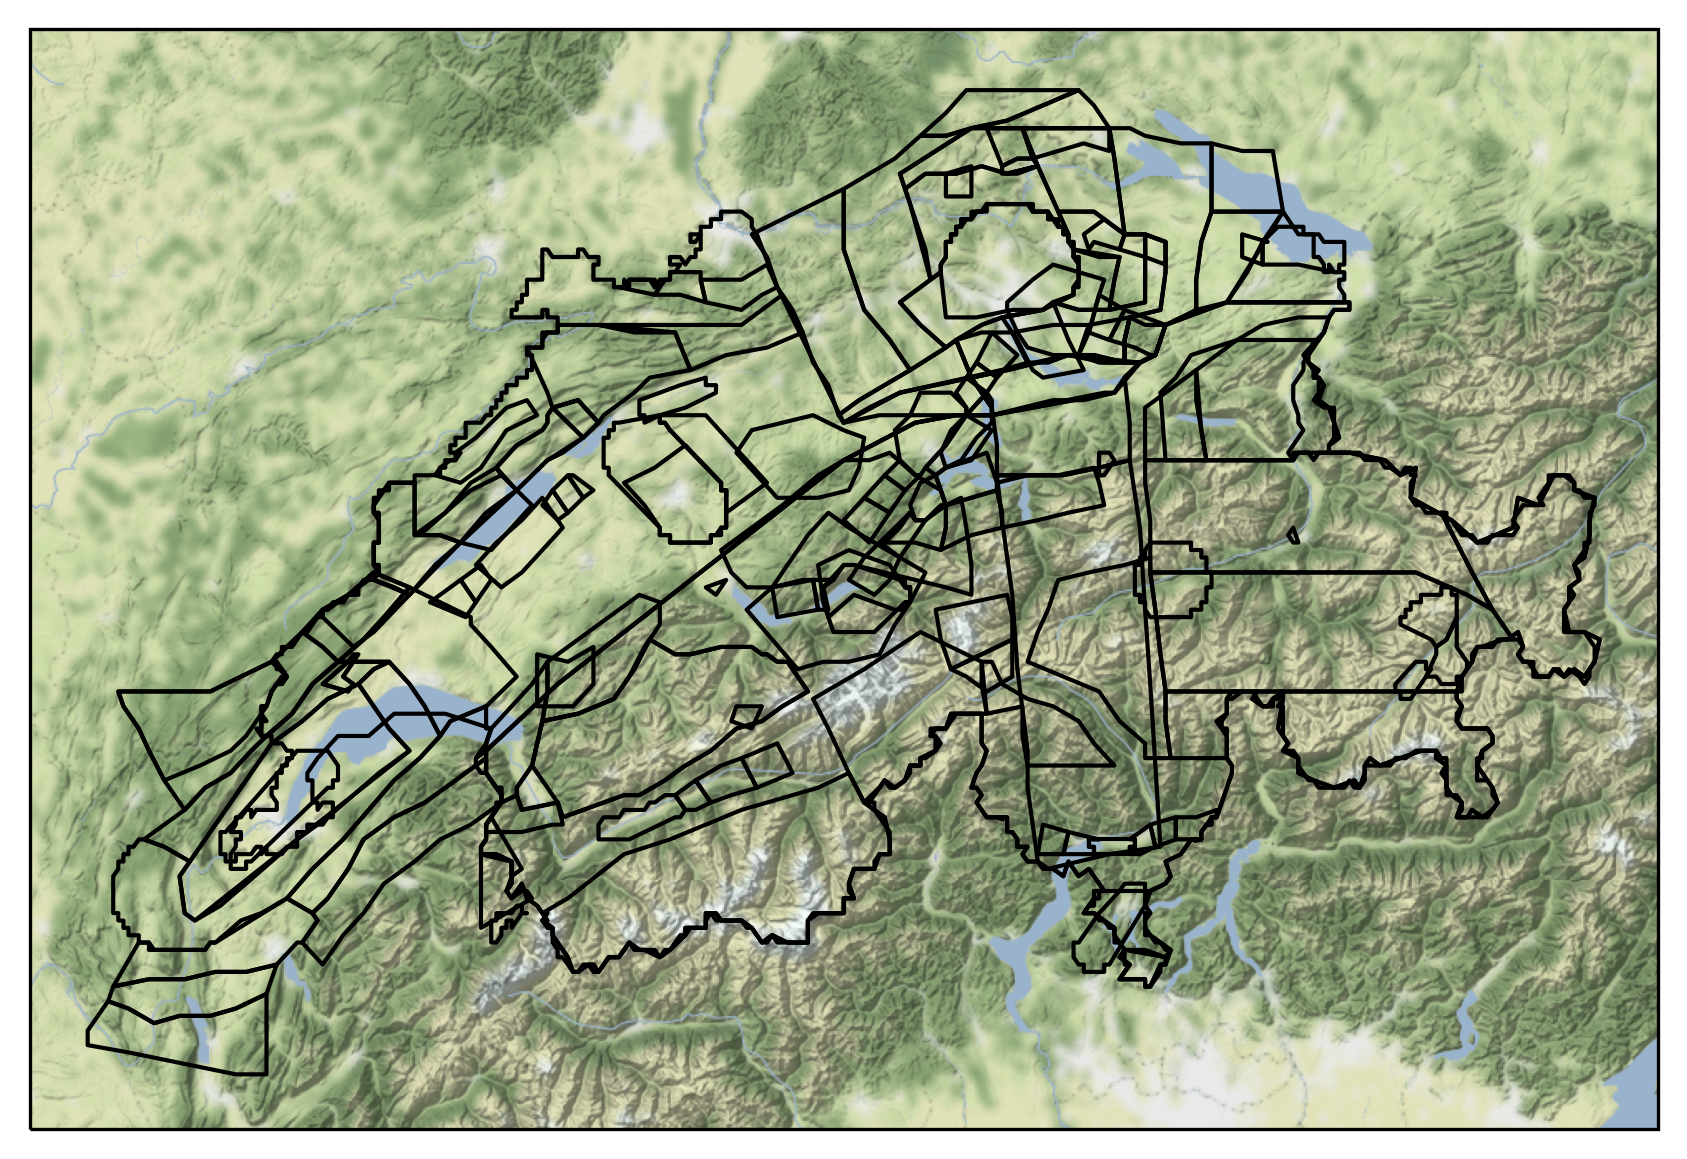

In [12]:
fig = plt.figure(dpi=300, figsize=(7,7))

imagery = cimgt.Stamen(style="terrain-background")
ax = plt.axes(projection=imagery.crs)

minlon = 5.3
maxlon = 10.7
minlat = 45.5
maxlat = 48

ax.set_extent((minlon, maxlon, minlat, maxlat))
ax.add_image(imagery, 8)

ax.add_geometries(gdf.geometry, crs=ccrs.PlateCarree(), facecolor="none", edgecolor="black")

ax.set_aspect('auto')

plt.show()

In [13]:
def filter_gdf(gdf, long, lat, height=None):
    loc = Point(long, lat)
    if height is not None:
        return gdf[(gdf.lower_limit < height) & (gdf.upper_limit > height) & gdf.geometry.contains(loc)]
    else:
        return gdf[gdf.geometry.contains(loc)]

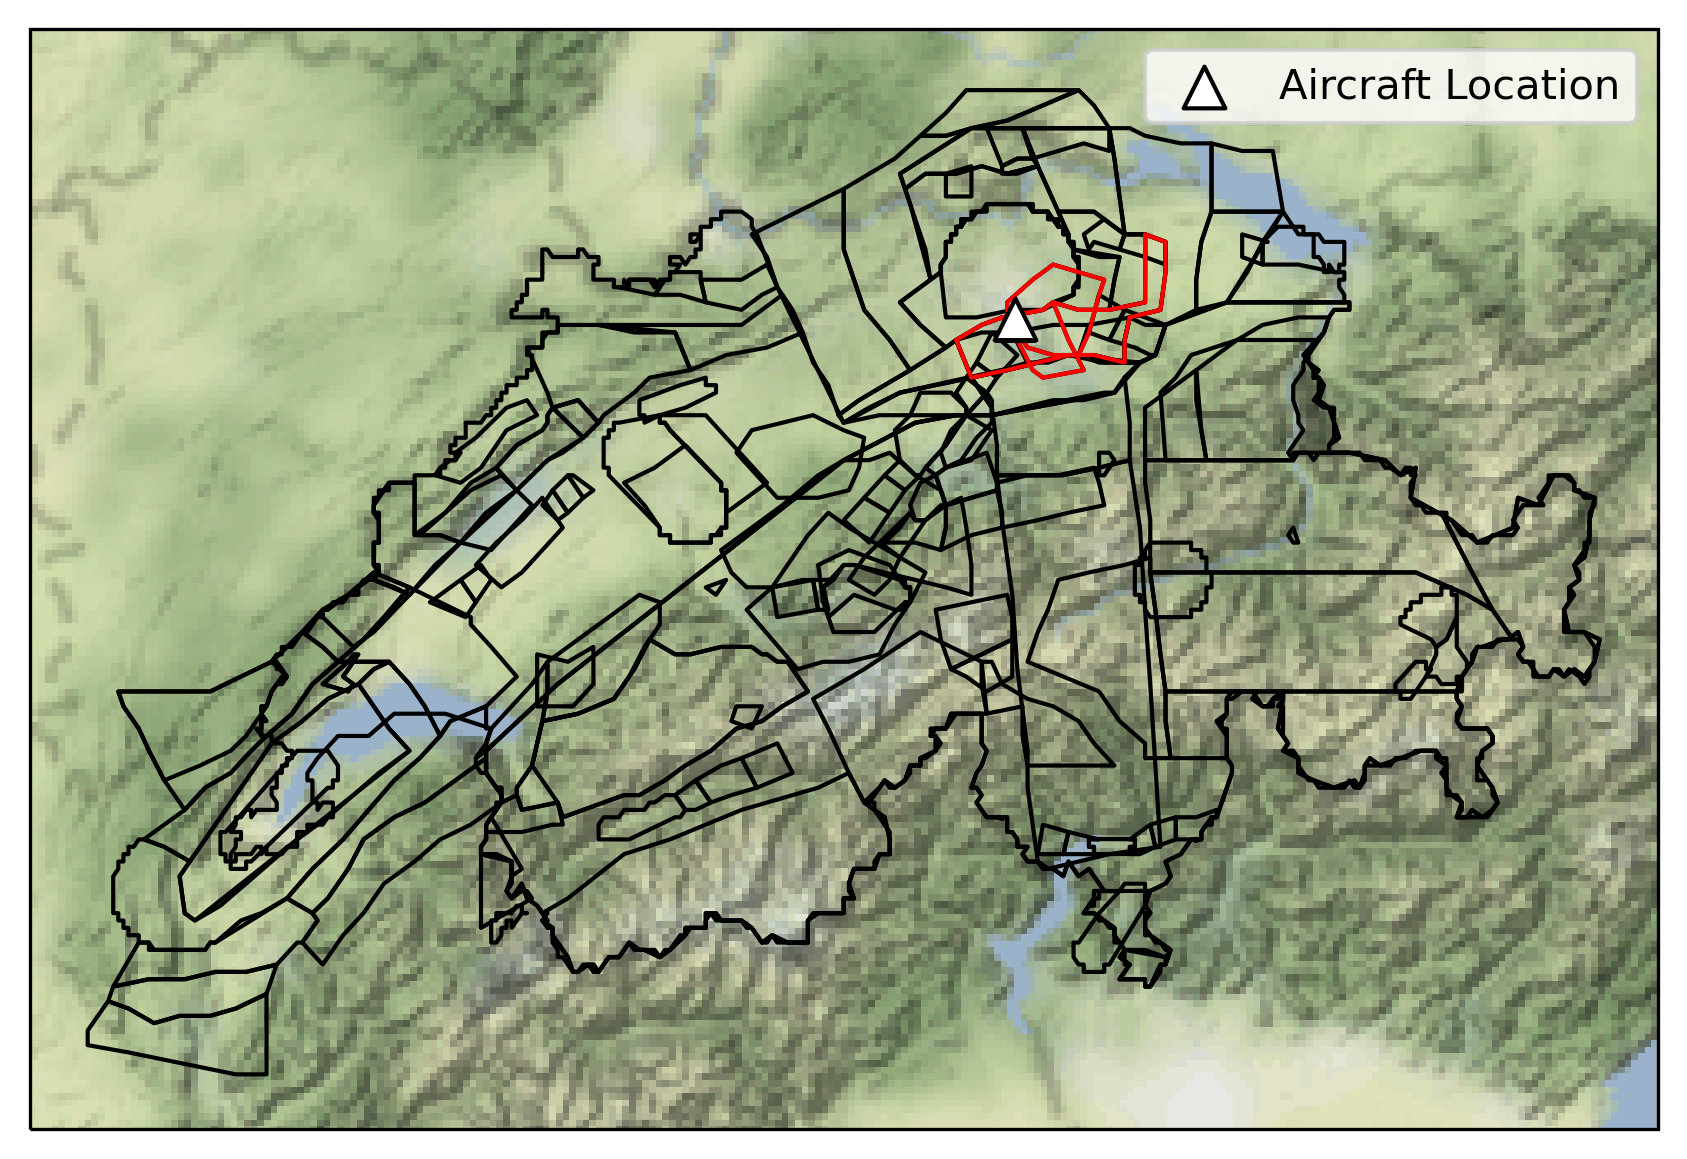

In [14]:
long = 8.567793
lat = 47.351863
gdf_filtered = filter_gdf(gdf, long, lat)


fig = plt.figure(dpi=300, figsize=(7,7))

imagery = cimgt.Stamen(style="terrain-background")
ax = plt.axes(projection=imagery.crs)

minlon = 5.3
maxlon = 10.7
minlat = 45.5
maxlat = 48

ax.set_extent((minlon, maxlon, minlat, maxlat))
ax.add_image(imagery, 6)

ax.add_geometries(gdf.geometry, crs=ccrs.PlateCarree(), facecolor="none", edgecolor="black")

ax.add_geometries(gdf_filtered.geometry, crs=ccrs.PlateCarree(), facecolor="none", edgecolor="red")
ax.scatter(long, lat, transform=ccrs.PlateCarree(), marker = "^", edgecolor="black", facecolor="white", s=100, zorder=10, label="Aircraft Location")

ax.legend(loc="upper right").set_zorder(100)
ax.set_aspect('auto')

plt.show()

## Export Data

We save the data to a file.

In [15]:
from flight_processing import DataConfig

In [16]:
config = DataConfig.known_dataset("switzerland")
out_location = config.dataset_location
out_location

'/mnt/cold_data/josh/processing/regions_switzerland_wkt.json'

In [17]:
gdf_out = gdf.drop(['upper_limit_raw', 'lower_limit_raw', 'coords_raw', 'coords'], axis=1).copy()
gdf_out['wkt'] = gdf_out.geometry.apply(lambda g: g.wkt)

gdf_out.to_file(out_location, driver="GeoJSON")

del gdf_out